In [33]:
eventsPath = os.environ["YAHOO_DATA"]
rawEventsRdd = sc.textFile(eventsPath + "events.txt")
rawInstallsRdd = sc.textFile(eventsPath + "installs.txt")
rawMergedRdd = rawEventsRdd.union(rawInstallsRdd)
def parseRawData(line):
    lineSplit = line.split("\t")
    return (lineSplit[0], #userid
              lineSplit[1], #itemid
              int(lineSplit[2]), #ts
              float(lineSplit[3]), #lat
              float(lineSplit[4]), #lon
              lineSplit[5], #city
              int(lineSplit[6]), #day_of_week
              int(lineSplit[7]), #time_of_day
              lineSplit[-1]) #event_type
    

eventsRdd = rawMergedRdd.map(parseRawData).cache()
#userIdConversionDictionary = eventsRdd.map(lambda x: x[0]).distinct().zipWithIndex().collectAsMap()
#itemIdConversionDictionary = eventsRdd.map(lambda x: x[1]).distinct().zipWithIndex().collectAsMap()
#cityConversionDictionary = eventsRdd.map(lambda x: x[5]).distinct().zipWithIndex().collectAsMap()
#USE the same id map always
import json
userIdConversionDictionary = json.load(open(eventsPath  + "/userIdConversionDictionary.txt"))
itemIdConversionDictionary = json.load(open(eventsPath  + "/itemIdConversionDictionary.txt"))
cityConversionDictionary = json.load(open(eventsPath  + "/cityConversionDictionary.txt"))
eventsConvertedRdd = eventsRdd.map(lambda x: (userIdConversionDictionary[x[0]],
    itemIdConversionDictionary[x[1]],
    x[2],
    x[3],
    x[4],
    cityConversionDictionary[x[5]],
    x[6],
    x[7],
    x[8]
    ))

eventsConvertedRdd.take(3)

[(163385,
  77275,
  1421009506,
  47.237476,
  -122.530884,
  13209,
  6,
  12,
  u'App_Opened'),
 (163385,
  44053,
  1421029924,
  47.237476,
  -122.530891,
  13209,
  6,
  18,
  u'App_Opened'),
 (163385,
  83370,
  1421015988,
  47.237461,
  -122.530899,
  13209,
  6,
  14,
  u'App_Opened')]

# Graphs on app usage

In [34]:
onlyOpenEvents = rawEventsRdd.map(
    parseRawData).map(lambda x : (itemIdConversionDictionary[x[1]],1))
appvsruntime = onlyOpenEvents.reduceByKey(lambda a,b : a + b).sortBy(lambda x: x[1], ascending=False)
appvsruntime.take(3)


[(29345, 9712865), (60075, 8431821), (79614, 7840438)]

In [36]:
import json
userappmap = json.load(open(eventsPath + "/userAppMap.txt"))
def findKey(d, v):
    for k, val in d.iteritems():
        if val == v:
            return k
listofapps = [ (findKey(itemIdConversionDictionary, v[0]), v[1]) for v in appvsruntime.take(100)]
stats_dir = eventsPath + "/stats/"
if not os.path.exists(stats_dir):
    os.makedirs(stats_dir)
numberOfEvents = float(eventsRdd.count())
outfile = open(stats_dir + "topapps_run_byusers.csv",'w')
outfile.write("App,#usersruntheapp, percentage\n")
for el in listofapps:
    outfile.write(str(el[0]) + "," + str(el[1]) + "," + str(el[1]/numberOfEvents) + '\n')
outfile.close()

### Number of open events vs application

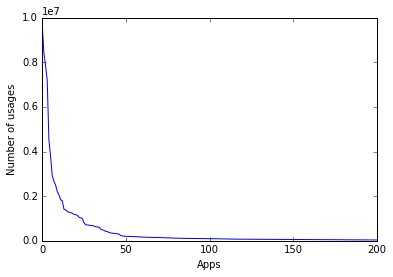

In [44]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
data= appvsruntime.map(lambda x : x[1]).collect()
plt.plot(data)
plt.ylabel('Number of usages')
plt.xlabel('Apps')
plt.axis([0,200,0 , 1e7])
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "numberofusagevsapp" + str(int(time.time())) + ".png")
plt.show()

### Percentage of usage over all events per app

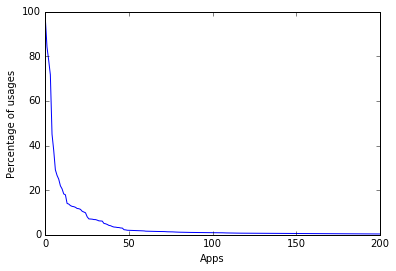

In [42]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
try:
    data
except NameError:
    data= appvsruntime.map(lambda x : x[1]).collect()
itemCount = float(len(data))
plt.plot([el/itemCount for el in data])
plt.ylabel('Percentage of usages')
plt.xlabel('Apps')
plt.axis([0,200,0 , 100])
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "percentageofusagevsapp" + str(int(time.time())) + ".png")
plt.show()


## Graphs of users installed per application

In [ ]:
userappmaprdd = sc.parallelize([ (int(k), userappmap[k]) for k in userappmap.keys()])
userappmaprdd = userappmaprdd.flatMap(lambda x : [ (k, 1) for k in x[1] ] ) #(itemid, 1) format
userappmaprdd = userappmaprdd.reduceByKey(
    lambda a,b : a + b).sortBy(lambda x : x[1], ascending=False)

In [ ]:
def findKey(d, v):
    for k, val in d.iteritems():
        if val == v:
            return k
listofapps = [ (findKey(itemIdConversionDictionary, v[0]), v[1]) for v in userappmaprdd.take(100)]
stats_dir = eventsPath + "/stats/"
if not os.path.exists(stats_dir):
    os.makedirs(stats_dir)
numberOfUsers = float(len(userappmap))
outfile = open(stats_dir + "topapps_owned_byusers.csv",'w')
outfile.write("App,#usersowntheapp, percentage\n")
for el in listofapps:
    outfile.write(str(el[0]) + "," + str(el[1]) + "," + str(el[1]/numberOfUsers) + '\n')
outfile.close()


### Number of users installed per application

In [ ]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
dataiteminstall= userappmaprdd.map(lambda x : x[1]).collect()
plt.plot(dataiteminstall)
plt.ylabel('Number of installs')
plt.xlabel('Apps')
plt.axis([0,10000, 0, 2000])
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "numberofinstallperapp" + str(int(time.time())) + ".png")
plt.show()

### Percentage of users installed per application

In [ ]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
try:
    dataiteminstall
except NameError:
    dataiteminstall= userappmaprdd.map(lambda x : x[1]).collect()
numberOfUsers = float(len(userappmap))
plt.plot([el/numberOfUsers for el in dataiteminstall])
plt.ylabel('Percentage of users own the app')
plt.xlabel('Apps')
plt.axis([0,1000, 0.0, 0.5])
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "percentageofusersownedvsapp" + str(int(time.time())) + ".png")
plt.show()

# Histogram of users having certain number of apps

In [10]:
import os
import numpy as np
execfile("../script/utils.py")
eventsPath = os.environ["YAHOO_DATA"]
splitedRdd = sc.textFile(eventsPath + "/splitedData")
splitedRdd = splitedRdd.map(parseContextData2).map(lambda x :  (len(x[1][1]) + len(x[1][0])))
intervalsLarge = np.arange(0,9001,1000).tolist()
histDataOpenlarge = splitedRdd.histogram(intervalsLarge)
intervalsSmall = np.arange(0,8601,100).tolist()
histDataOpenSmall = splitedRdd.histogram(intervalsSmall)
#splitedRdd.max() 8597

In [17]:
histDataOpenlarge

([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000],
 [170547, 26967, 3287, 498, 113, 21, 11, 3, 3])

### Histogram of number opens per user 1000 interval adopted

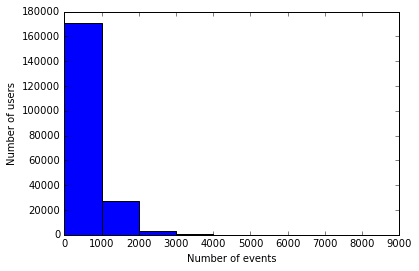

In [24]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
plt.bar(histDataOpenlarge[0][:-1], histDataOpenlarge[1], width=1000 )
plt.ylabel('Number of users')
plt.xlabel('Number of events')
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "histof_#opens_peruser_1000int" + str(int(time.time())) + ".png")
plt.show()

### Histogram of number opens per user 100 interval adopted

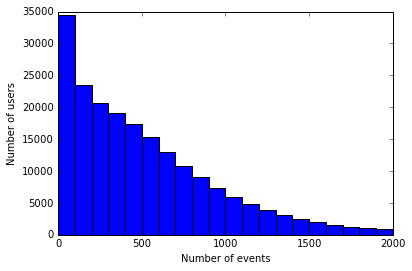

In [25]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
plt.bar(histDataOpenSmall[0][:-1], histDataOpenSmall[1], width=100 )
plt.ylabel('Number of users')
plt.xlabel('Number of events')
plt.axis([0,2000,0,35000])
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "histof_#opens_peruser_100int" + str(int(time.time())) + ".png")
plt.show()

### Histogram of the number of applications owned by each user

In [28]:
import json
userappmap = json.load(open(eventsPath + "/userAppMap.txt"))
userappcountrdd = sc.parallelize([len(v) for k,v in userappmap.iteritems()])
intervalAppCount = [0,10,20,30,40,50,60,70,100,150,200,260]
histDataAppcount = userappcountrdd.histogram(intervalAppCount)
userappcountrdd.mean(), userappcountrdd.max(), userappcountrdd.count()

(33.15867957309499, 257, 201450)

In [30]:
histDataAppcount

([0, 10, 20, 30, 40, 50, 60, 70, 100, 150, 200, 260],
 [10369, 28266, 47468, 52043, 35778, 17107, 6501, 3589, 303, 23, 3])

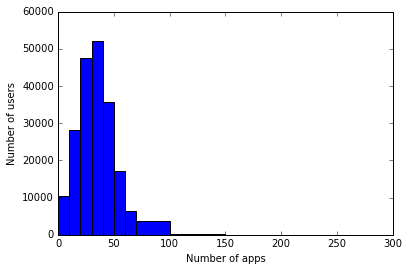

In [31]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
plt.bar(histDataAppcount[0][:-1], histDataAppcount[1],
        width=[x - intervalAppCount[i - 1] for i, x in enumerate(intervalAppCount)][1:])
plt.ylabel('Number of users')
plt.xlabel('Number of apps')

#figure_dir = eventsPath + "/figures/"
#if not os.path.exists(figure_dir):
#    os.makedirs(figure_dir)
#plt.savefig(figure_dir + "histof_#opens_peruser_100int" + str(int(time.time())) + ".png")
plt.show()

In [32]:
len(itemIdConversionDictionary)

100259

In [2]:
eventRDD = eventsConvertedRdd.groupBy(lambda x: x[0]).map(lambda (x,y): (x, sorted(list(y),key=lambda a: a[2])))
def tempRemoveUserIdDup(line):
    data = line[1]
    newData = [el[1:] for el in data]
    return line[0], newData
eventRDD2 = eventRDD.map(tempRemoveUserIdDup)

In [ ]:
def splitRddMerged(line):
    open_events = [el for el in line[1] if el[7] == "App_Opened"]
    install_events = [el for el in line[1] if el[7] == "install"]
    uninstall_events = [el for el in line[1] if el[7] == "uninstall"]
    return line[0],open_events, install_events, uninstall_events
splited = eventRDD2.map(splitRddMerged)
splited.collect()

In [4]:
outp = open(eventsPath + "/outputstat.txt","a")
import datetime
import time
outp.write("--------------------------------------------------------\n") #separator
outp.write(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))
outp.write("\n")
numberofusers = splited.count()
outp.write("Number of users : " + str(numberofusers) + "\n")
install = eventsConvertedRdd.filter(lambda x : x[8]=="install").count()
uninstall = eventsConvertedRdd.filter(lambda x : x[8]=="uninstall").count()
app_open = eventsConvertedRdd.filter(lambda x : x[8]=="App_Opened").count()
outp.write("Number of events(install, uninstall, open, all) : " 
           + str((install, uninstall, app_open, install + uninstall + app_open)) + "\n")
outp.write("Average number of events per user(install, uninstall, open, all) : " 
           + str((install/float(numberofusers), uninstall/float(numberofusers), 
                  app_open/float(numberofusers), 
                  (install + uninstall + app_open)/float(numberofusers))) + "\n")
outp.close()

200